In [106]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
train = pd.read_csv('data/train.csv', 
                    dtype={'fullVisitorId' : str, 'visitId' : str}).sample(frac=1).reset_index(drop=True)

In [122]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   channelGrouping                 903653 non-null  object        
 1   date                            903653 non-null  datetime64[ns]
 2   fullVisitorId                   903653 non-null  object        
 3   sessionId                       903653 non-null  object        
 4   visitId                         903653 non-null  object        
 5   visitNumber                     903653 non-null  int64         
 6   visitStartTime                  903653 non-null  datetime64[ns]
 7   browser                         903653 non-null  object        
 8   operatingSystem                 903653 non-null  object        
 9   isMobile                        903653 non-null  bool          
 10  deviceCategory                  903653 non-null  object 

,visitNumber,hits,newVisits,bounces,transactionRevenue,adwordsClickInfo.page
count,903653.000000,903653.000000,903653.000000,903653.000000,9.036530e+05,903653.000000
mean,2.264897,4.596538,0.778020,0.498676,1.704273e+06,1.008108
std,9.283735,9.641437,0.415578,0.499999,5.277866e+07,0.026749
min,1.000000,1.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000e+00,1.008108
50%,1.000000,2.000000,1.000000,0.000000,0.000000e+00,1.008108
75%,1.000000,4.000000,1.000000,1.000000,0.000000e+00,1.008108
max,395.000000,500.000000,1.000000,1.000000,2.312950e+10,14.000000


In [124]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,...,campaign,source,medium,isTrueDirect,keyword,adContent,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType
0,Referral,2016-11-19,6223231860693237770,6223231860693237770_1479614285,1479614285,3,2016-11-20 03:58:05,Chrome,Macintosh,False,...,(not set),mall.googleplex.com,referral,False,NaN,NaN,1.008108,unknown,NaN,NaN
1,Social,2016-11-27,7574405497953320031,7574405497953320031_1480267674,1480267674,1,2016-11-27 17:27:54,Chrome,Windows,False,...,(not set),youtube.com,referral,False,NaN,NaN,1.008108,unknown,NaN,NaN
2,Referral,2017-01-22,5341143402971547934,5341143402971547934_1485107821,1485107821,1,2017-01-22 17:57:01,Chrome,Macintosh,False,...,(not set),mall.googleplex.com,referral,False,NaN,NaN,1.008108,unknown,NaN,NaN
3,Referral,2016-09-06,8879290650006947914,8879290650006947914_1473181787,1473181787,4,2016-09-06 17:09:47,Chrome,Macintosh,False,...,(not set),mall.googleplex.com,referral,True,NaN,NaN,1.008108,unknown,NaN,NaN
4,Paid Search,2017-05-07,635267852982141680,635267852982141680_1494144240,1494144240,1,2017-05-07 08:04:00,Chrome,Windows,False,...,AW - Electronics,google,cpc,False,+sunglasses +online,Want Google Sunglasses,1.000000,Top,Cj0KCQjwi7vIBRDpARIsANQsFdj5ReHQ4MS2OGh0YJAnOl...,Google Search


### Преобразование JSON в столбцы

In [110]:
train.date = pd.to_datetime(train.date, format='%Y%m%d')
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
train = pd.merge(left=train, right=pd.json_normalize(train.device.apply(json.loads)), 
                 left_index=True, right_index=True).drop('device', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.geoNetwork.apply(json.loads)), 
                 left_index=True, right_index=True).drop('geoNetwork', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.totals.apply(json.loads)), 
                 left_index=True, right_index=True).drop('totals', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.trafficSource.apply(json.loads)), 
                 left_index=True, right_index=True).drop('trafficSource', axis=1)

### Получение количественных, булевых и временных характеристик

In [111]:
train.isTrueDirect = train.isTrueDirect.fillna(False)
train.hits = train.hits.astype(int)
train.visits = train.visits.astype(int)
train.pageviews = train.pageviews.fillna(train.pageviews.astype(float).mean()).astype(int)
train.newVisits = train.newVisits.fillna(0).astype(int)
train.bounces = train.bounces.fillna(0).astype(int)
train.transactionRevenue = train.transactionRevenue.fillna(0).astype(float)
train['adwordsClickInfo.page'] = train['adwordsClickInfo.page'].astype(float)
train['adwordsClickInfo.page'] = train['adwordsClickInfo.page'].fillna(train['adwordsClickInfo.page'].mean())
train['adwordsClickInfo.slot'] = train['adwordsClickInfo.slot'].fillna('unknown')
train['adwordsClickInfo.slot'] = train['adwordsClickInfo.slot'].astype('category')

### Нахождение вероятных категориальных признаков

In [120]:
for c in train:
    if train[c].nunique() <= 50:
        print(c, train[c].nunique())

channelGrouping 8
operatingSystem 20
isMobile 2
deviceCategory 3
continent 6
subContinent 23
newVisits 2
bounces 2
campaign 10
medium 7
isTrueDirect 2
adContent 44
adwordsClickInfo.page 9
adwordsClickInfo.slot 3
adwordsClickInfo.adNetworkType 2


### Удаление столбцов с одним значением

In [117]:
for c in train:
    if train[c].nunique() == 1:
        train = train.drop(c, axis=1)

### Просмотр корреляции между признаками

In [118]:
corr_matrix = train.drop(set(train.select_dtypes(include=['object', 'bool']).columns).union(['transactionRevenue']) , axis=1).corr()

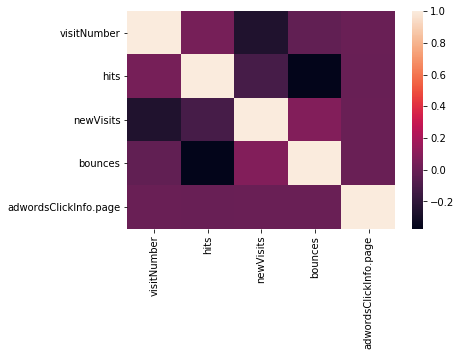

In [119]:
sns.heatmap(corr_matrix)

### Удаление признака, у которого большая корреляция с другим признаком

In [115]:
train = train.drop('pageviews', axis=1)

### Получение категориальных признаков, количество уникальных значений которых меньше 5

In [9]:
for c in train:
    if 2 < train[c].nunique() < 5:
        train[c] = train[c].astype('category').cat.codes

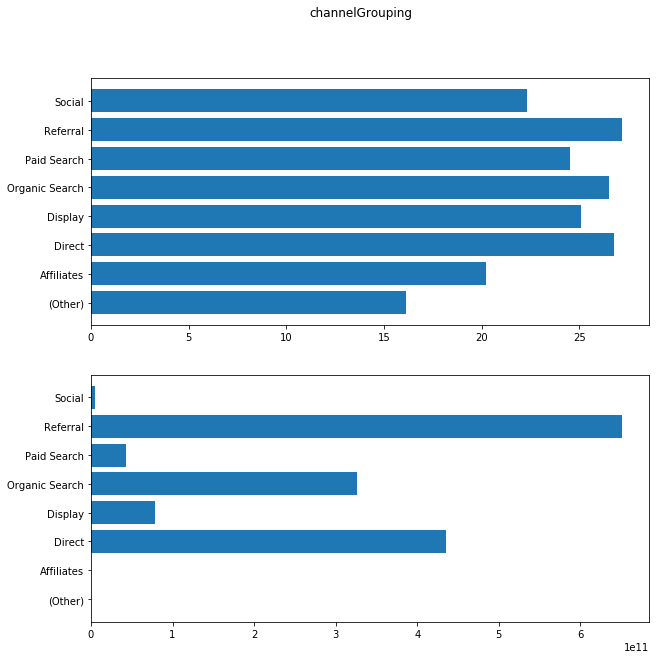

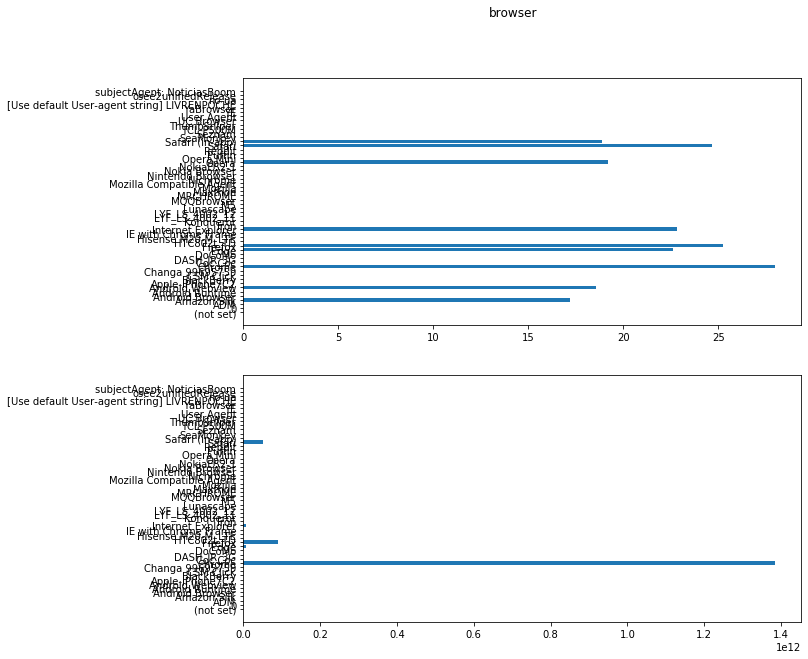

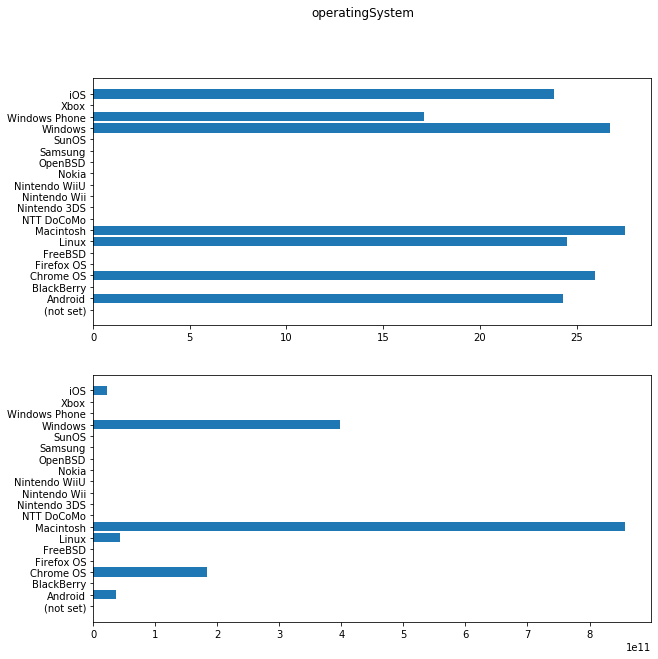

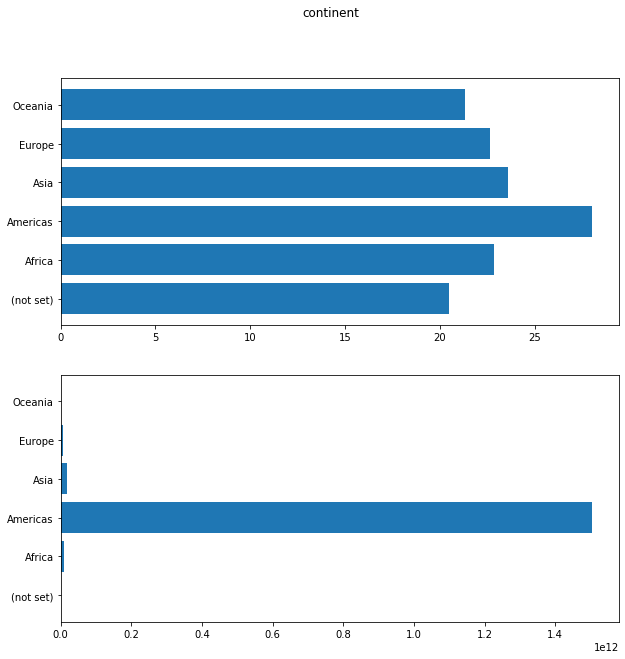

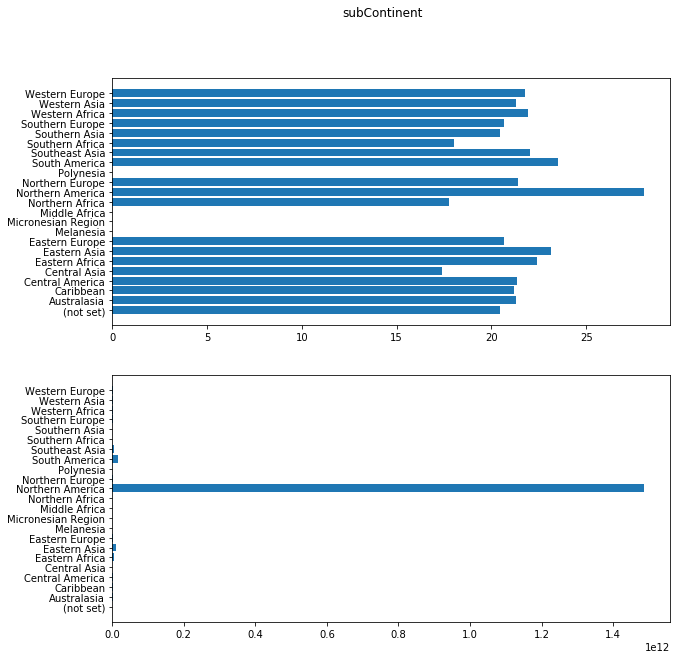

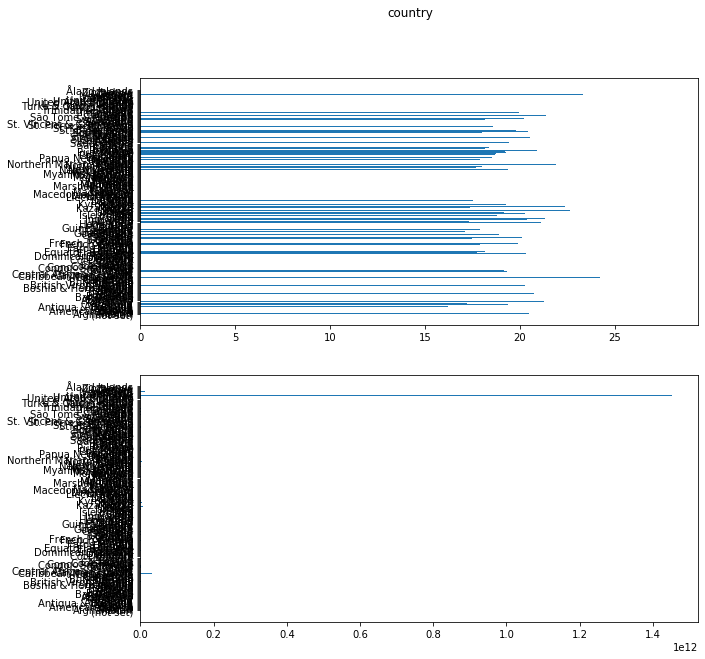

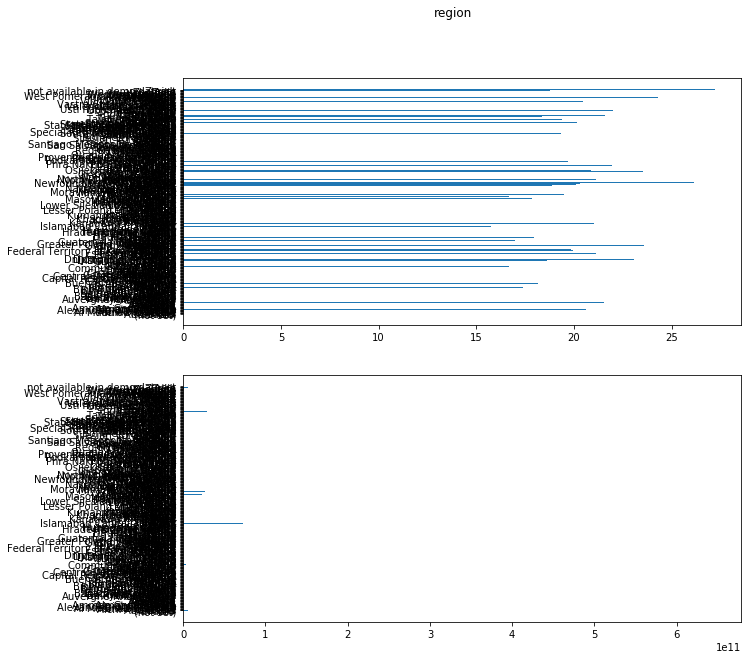

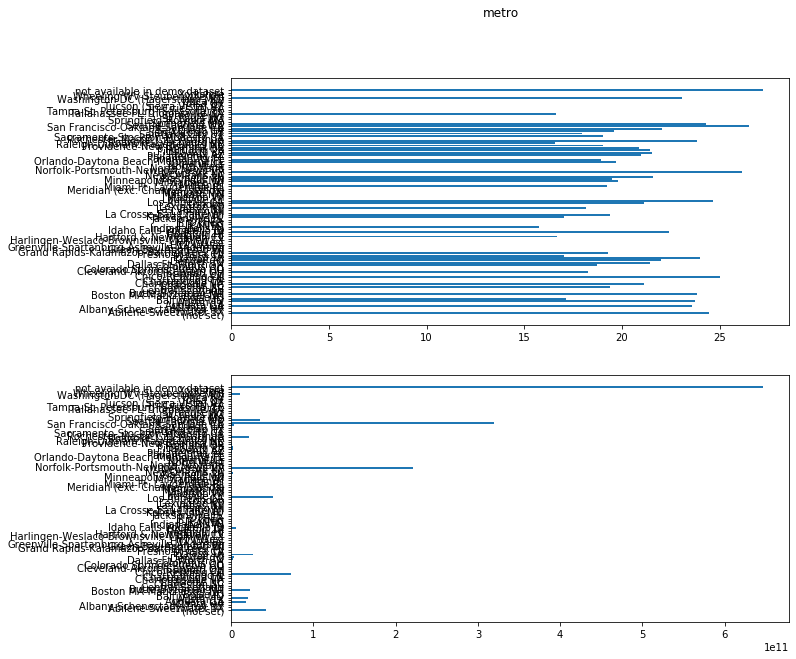

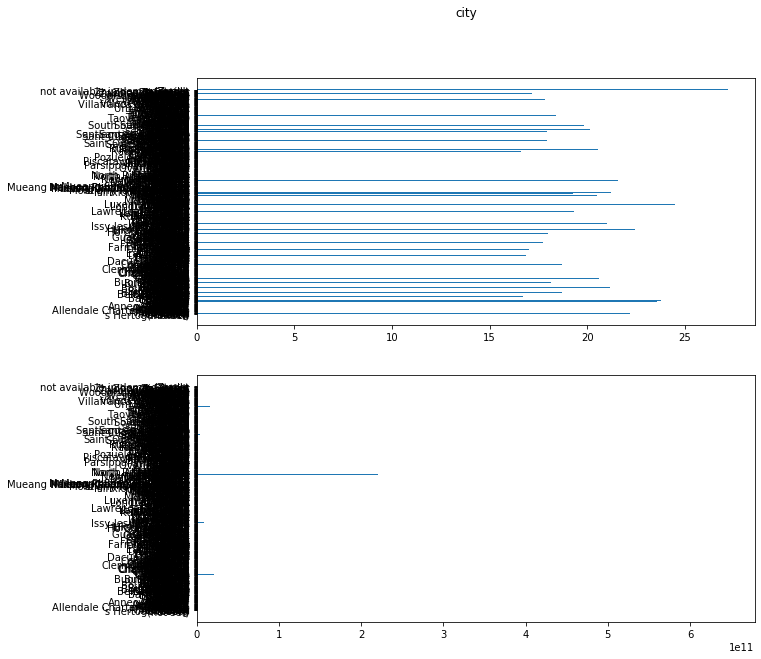

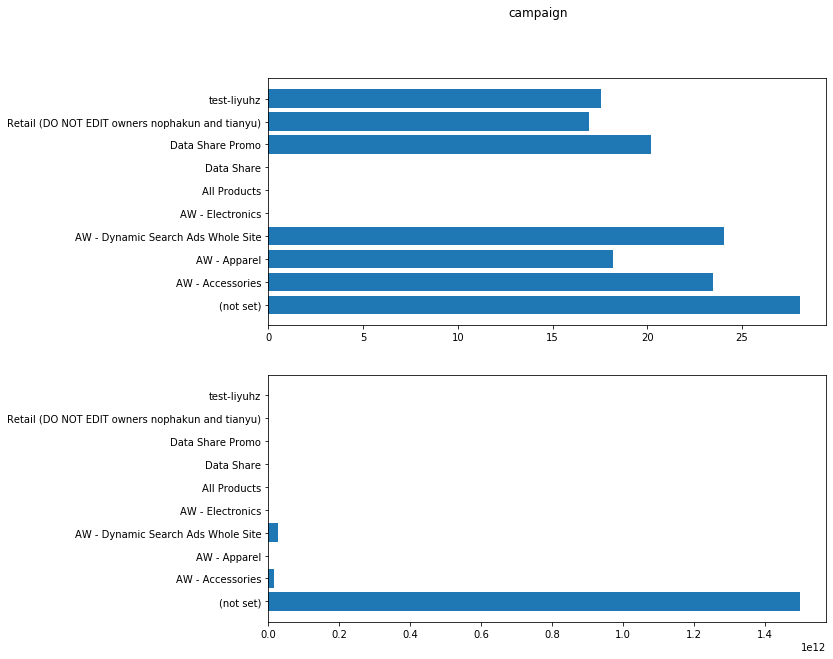

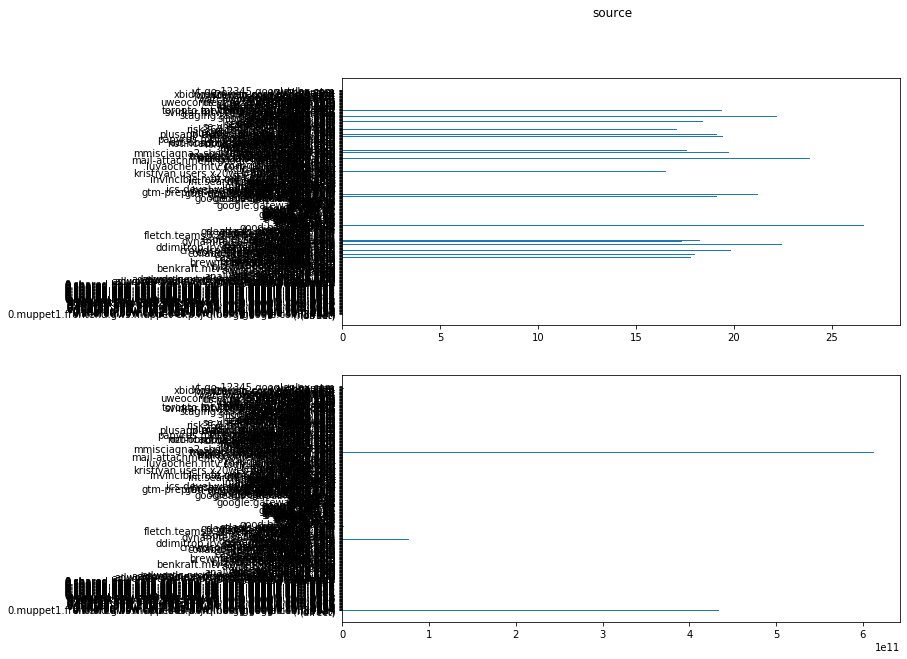

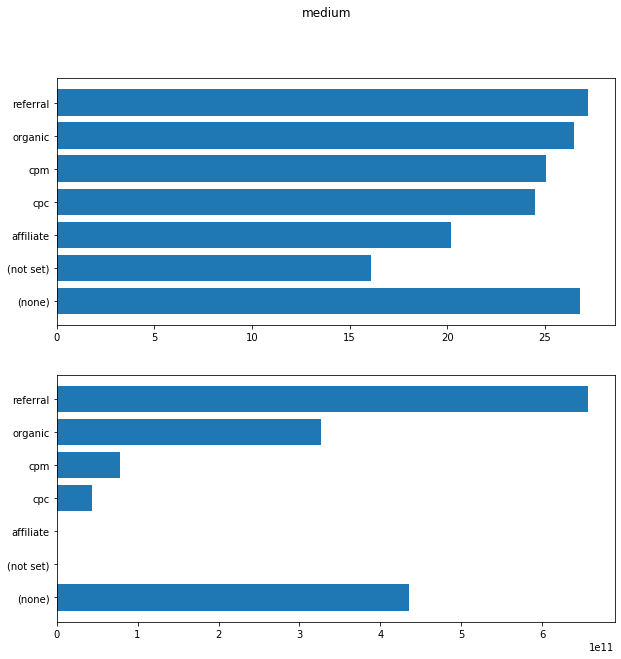

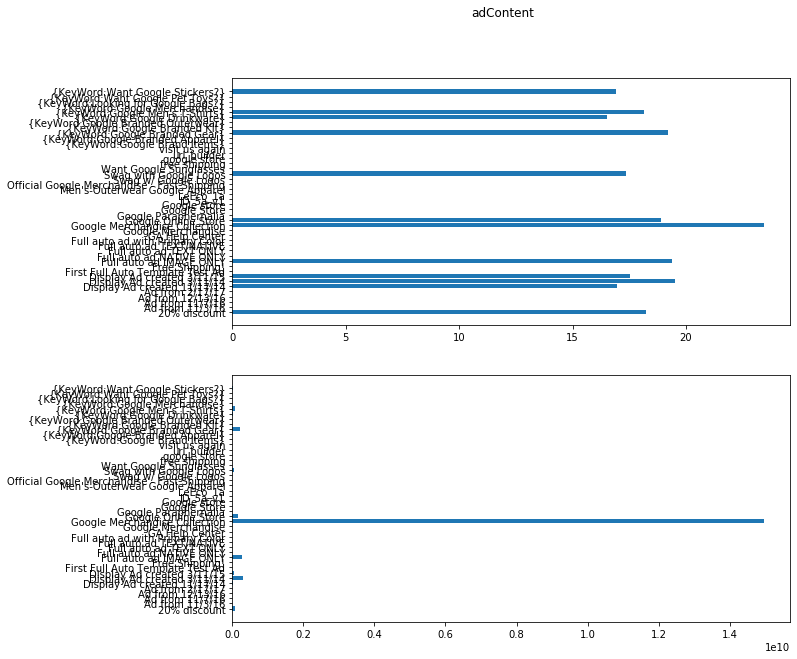

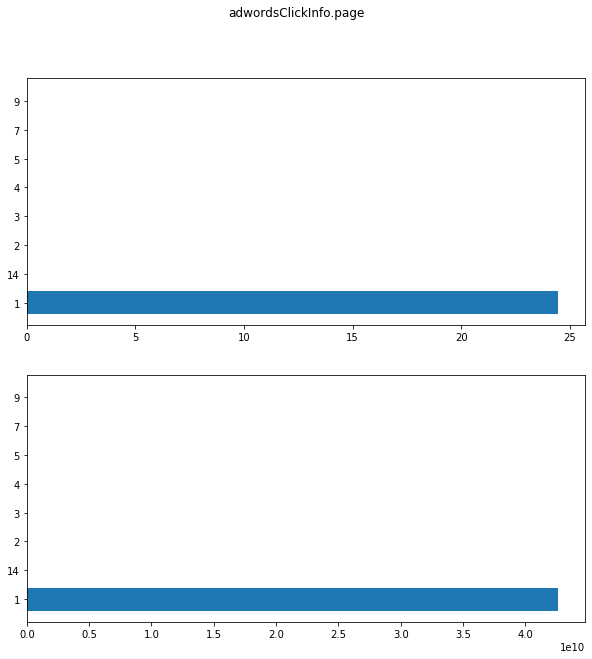

In [10]:
for c in train:
    if 5 <= train[c].nunique() <= 1000 and train[c].dtype == 'object':
        fig, axs = plt.subplots(2, figsize=(10, 10))
        fig.suptitle(c)
        grouped = train.groupby(c).transactionRevenue.sum().reset_index()
        axs[0].barh(grouped[c], np.log(1 + grouped.transactionRevenue))
        axs[1].barh(grouped[c], grouped.transactionRevenue)
        plt.show()

In [11]:
def get_codes_by_conditions(column, df, conditions):
    df = df.groupby(column).transactionRevenue.sum().reset_index()
    codes = {}
    value = np.log(1 + df.transactionRevenue)
    for c in range(len(conditions) - 1):
        values = df.loc[(conditions[c] <= value) & (value < conditions[c + 1])][column]
        for v in values:
            codes[v] = c
    return codes

In [12]:
def show_subplots(column, df):
    fig, axs = plt.subplots(2, figsize=(10, 10))
    fig.suptitle(column)
    grouped = df.groupby(column).transactionRevenue.sum().reset_index()
    axs[0].barh(grouped[column], np.log(1 + grouped.transactionRevenue))
    axs[1].barh(grouped[column], grouped.transactionRevenue)
    plt.show()

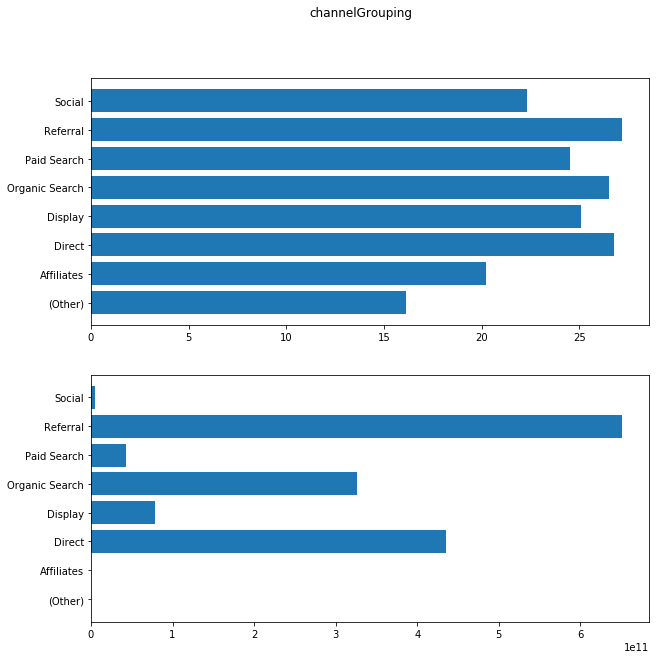

In [13]:
show_subplots('channelGrouping', train)

In [14]:
conditions = [0, 15, 23, 30]
train.channelGrouping = train.channelGrouping.map(get_codes_by_conditions('channelGrouping', train, conditions))

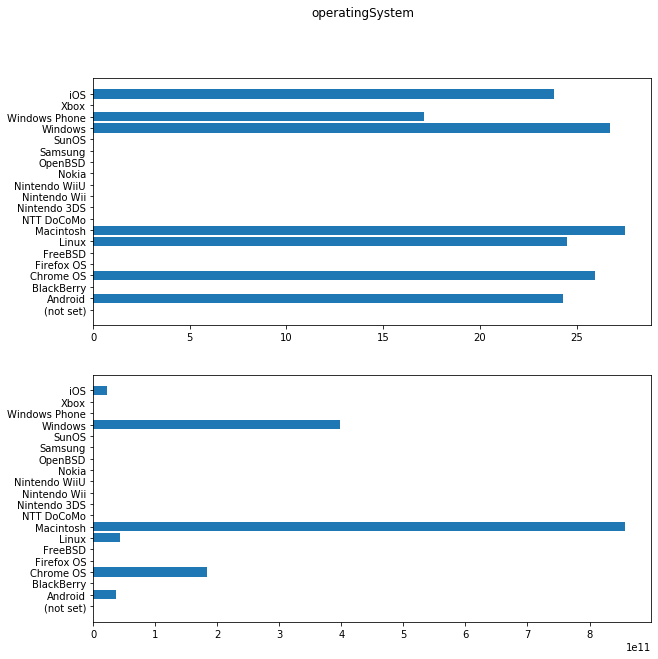

In [15]:
show_subplots('operatingSystem', train)

In [16]:
conditions = [0, 15, 20, 24, 30]
train.operatingSystem = train.operatingSystem.map(get_codes_by_conditions('operatingSystem', train, conditions))

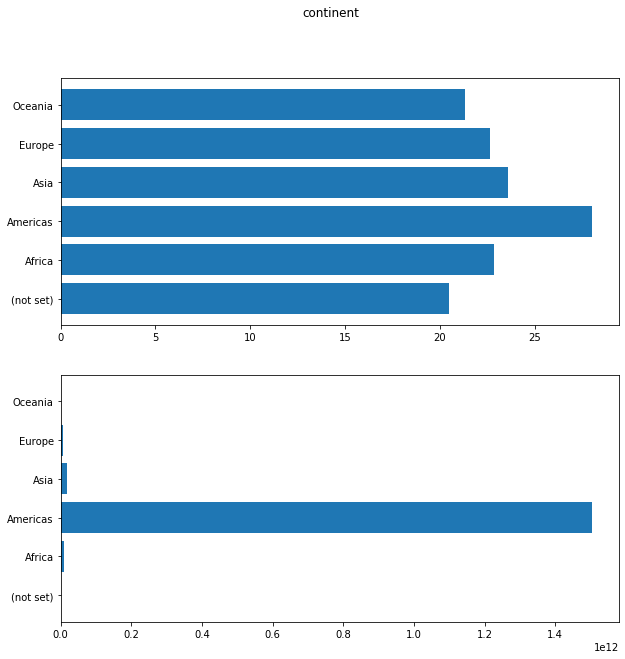

In [17]:
show_subplots('continent', train)

In [18]:
conditions = [0, 15, 25, 30]
train.continent = train.continent.map(get_codes_by_conditions('continent', train, conditions))

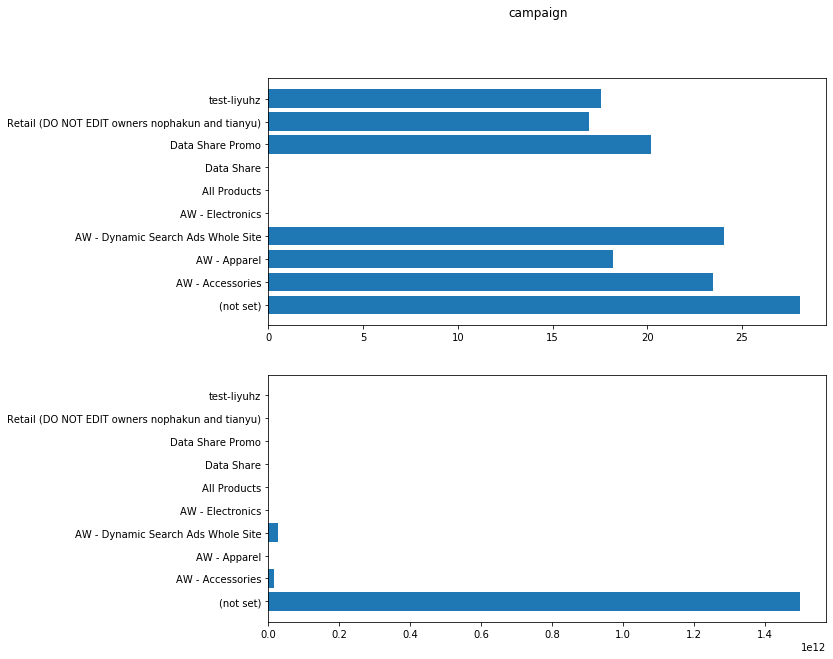

In [19]:
show_subplots('campaign', train)

In [20]:
conditions = [0, 15, 25, 30]
train.medium = train.medium.map(get_codes_by_conditions('medium', train, conditions))

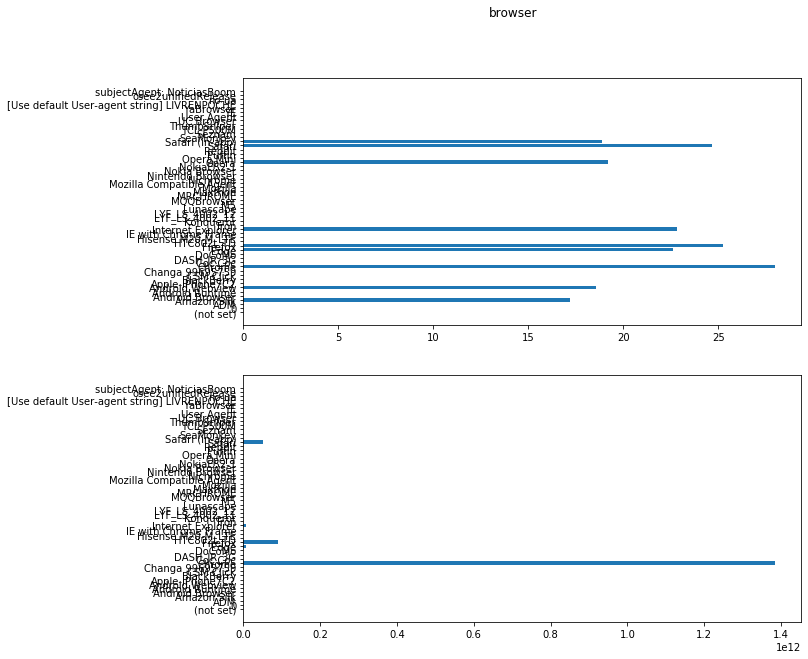

In [21]:
show_subplots('browser', train)

In [22]:
conditions = [0, 15, 22.5, 25, 30]
train.browser = train.browser.map(get_codes_by_conditions('browser', train, conditions))

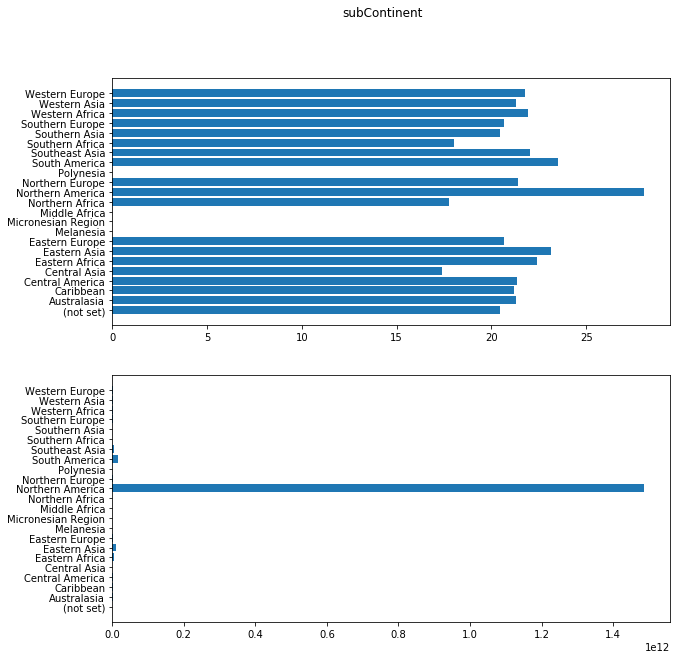

In [23]:
show_subplots('subContinent', train)

In [24]:
conditions = [0, 15, 20, 25, 30]
train.subContinent = train.subContinent.map(get_codes_by_conditions('subContinent', train, conditions))

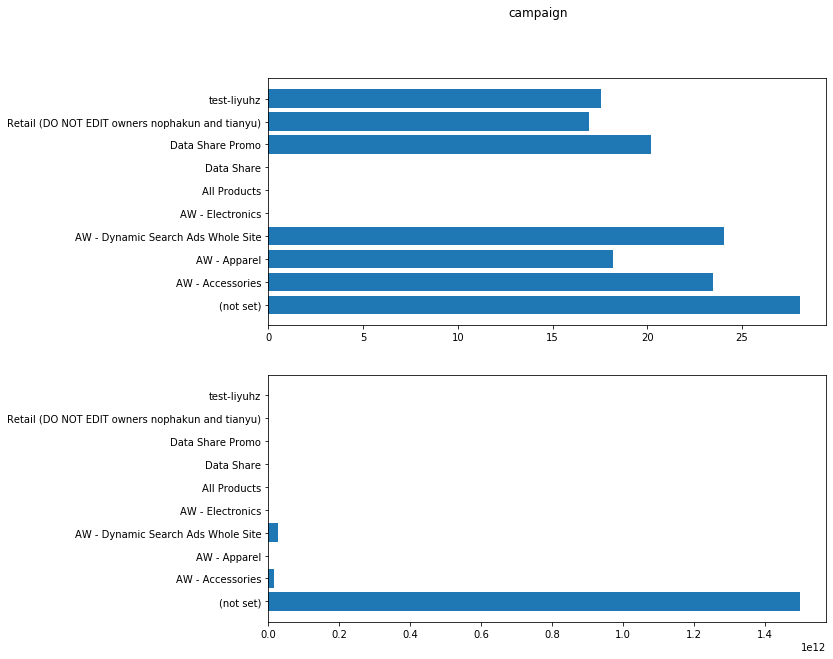

In [25]:
show_subplots('campaign', train)

In [26]:
conditions = [0, 15, 25, 30]
train.campaign = train.campaign.map(get_codes_by_conditions('campaign', train, conditions))

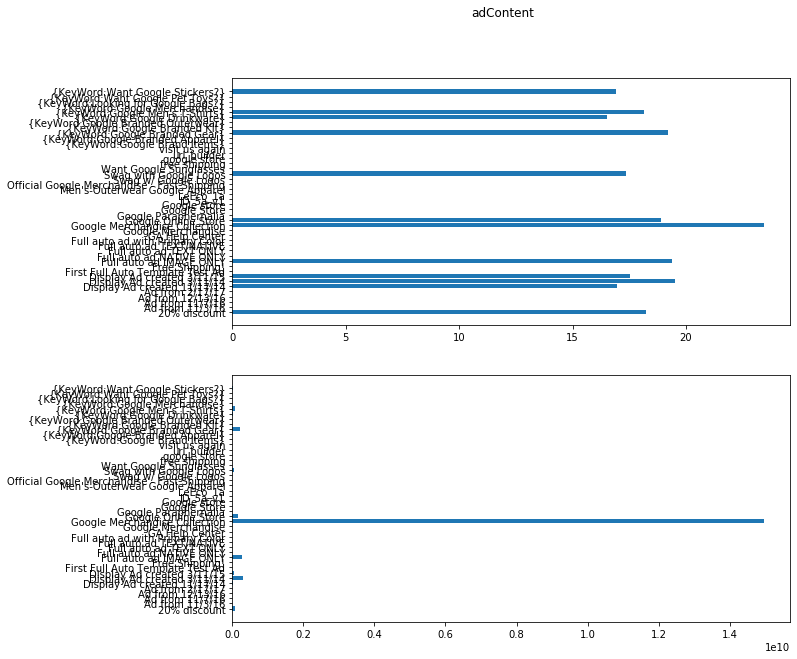

In [27]:
show_subplots('adContent', train)

In [28]:
conditions = [0, 15, 20, 30]
train.adContent = train.adContent.map(get_codes_by_conditions('adContent', train, conditions))

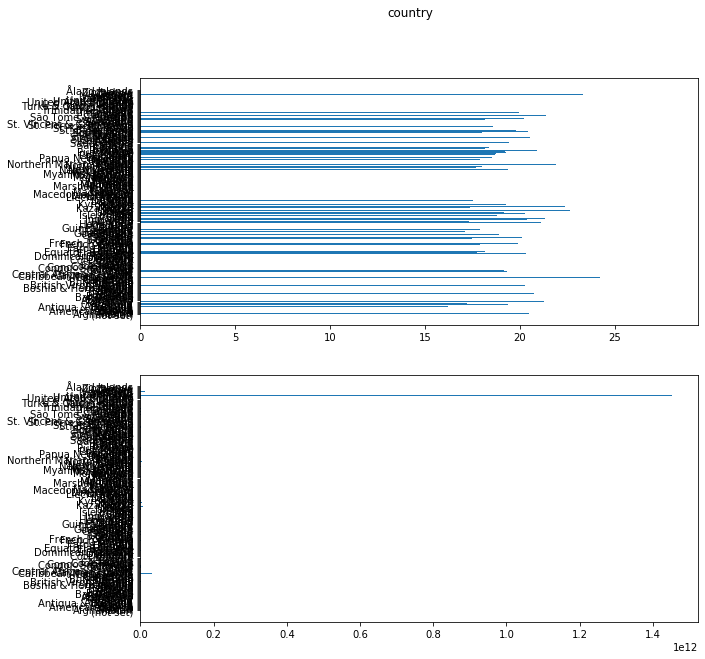

In [29]:
show_subplots('country', train)

In [30]:
conditions = [0, 15, 21, 25, 30]
train.country = train.country.map(get_codes_by_conditions('country', train, conditions))

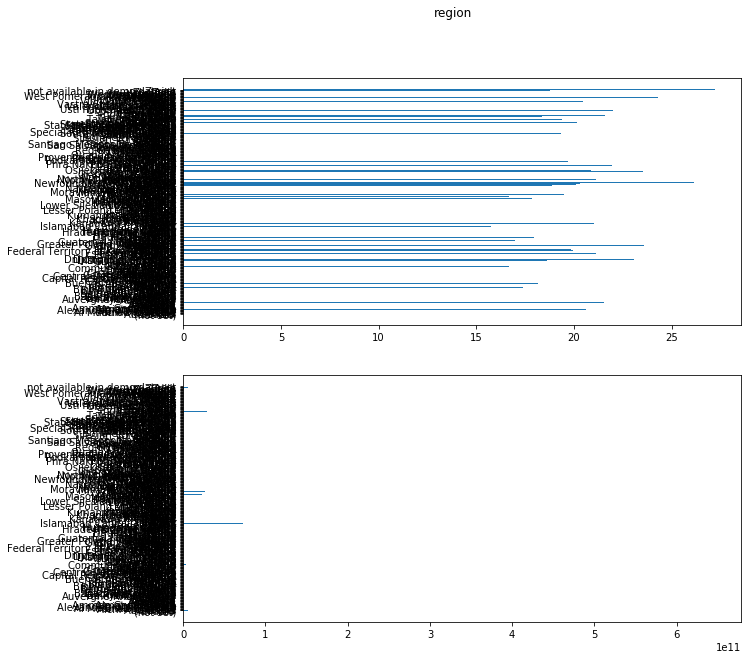

In [31]:
show_subplots('region', train)

In [32]:
conditions = [0, 15, 20, 23, 30]
train.region = train.region.map(get_codes_by_conditions('region', train, conditions))

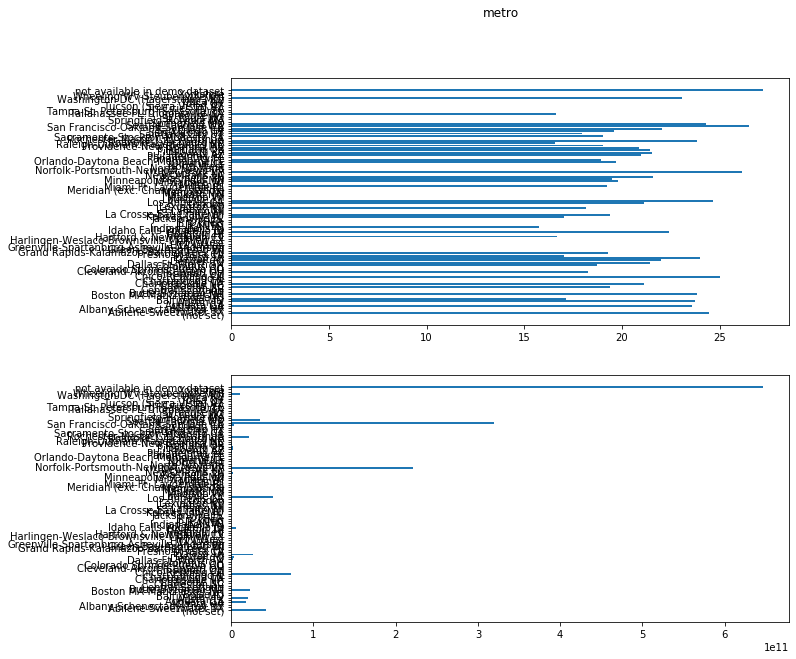

In [33]:
show_subplots('metro', train)

In [34]:
conditions = [0, 15, 20, 24, 30]
train.metro = train.metro.map(get_codes_by_conditions('metro', train, conditions))

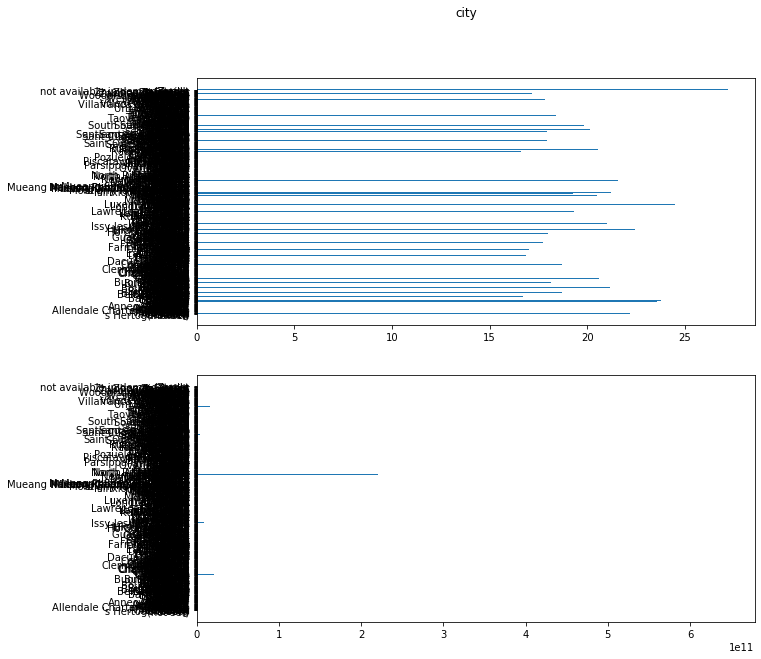

In [35]:
show_subplots('city', train)

In [36]:
conditions = [0, 15, 21, 24, 30]
train.city = train.city.map(get_codes_by_conditions('city', train, conditions))

In [ ]:
train = train.drop(['city', 'country', 'continent', 'campaign', 'pageviews'], axis=1)

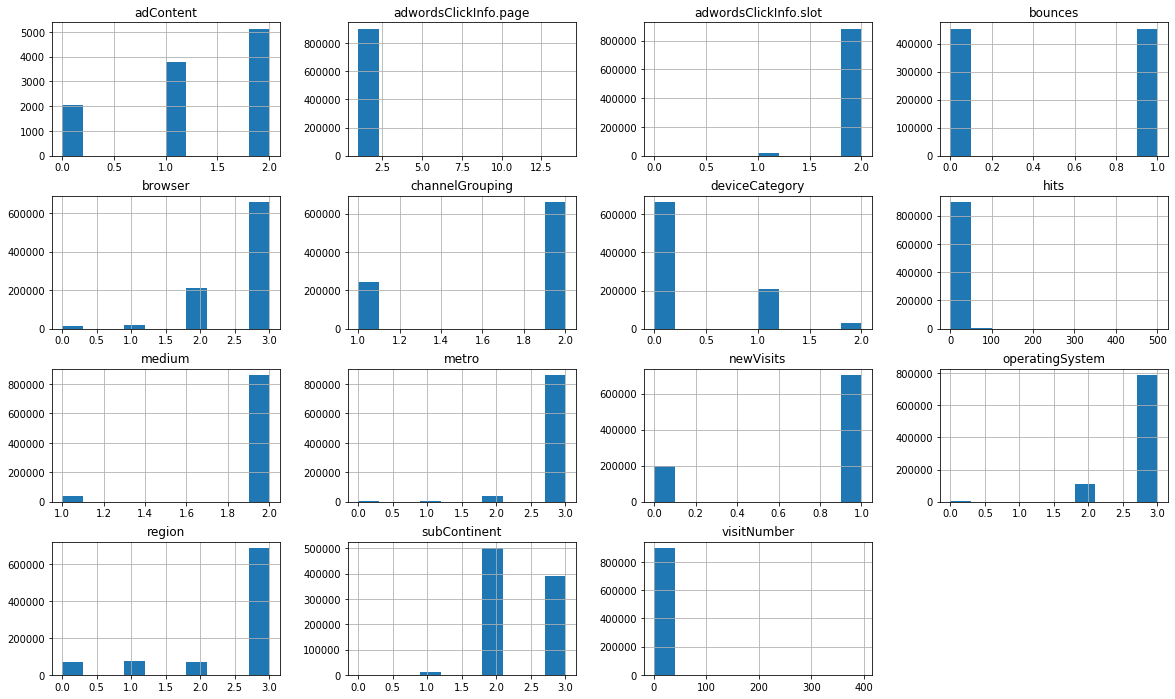

In [102]:
features = list(set(train.select_dtypes(exclude=['object', 'bool']).columns) - set(['transactionRevenue']))
train[features].hist(figsize=(20,12));

In [72]:
!pip install mlxtend

In [73]:
df = pd.merge(left=train.fullVisitorId, right=train.select_dtypes(exclude=['object']), 
              left_index=True, right_index=True)
df = df.groupby('fullVisitorId').sum().reset_index()

In [74]:
columns = {}
df = pd.merge(left=train.fullVisitorId, right=train.select_dtypes(exclude=['object']), 
              left_index=True, right_index=True)
for c in df:
    if df[c].nunique() <= 10:
        columns[c] = 'min'
columns['transactionRevenue'] = 'sum'
df = df.groupby('fullVisitorId').agg(columns).reset_index()
df.adContent = df.adContent.fillna(-1)

In [75]:
X = df.drop(['fullVisitorId', 'transactionRevenue'], axis=1)
y = np.log(df.transactionRevenue + 1)

In [76]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

selector = SequentialFeatureSelector(LinearRegression(), verbose=2, k_features=5, forward=False, n_jobs=-1)
selector.fit(X, y)
selector.subsets_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:   17.6s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   28.0s finished

[2020-05-10 13:09:27] Features: 12/5 -- score: 0.056447752820656574[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   12.8s remaining:   25.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   20.0s finished

[2020-05-10 13:09:47] Features: 11/5 -- score: 0.05644925218532881[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    8.6s remaining:   39.0s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:   14.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   16.1s finished

[2020-05-10 13:10:03] Features: 10/5 -- score: 0.056448529213296815[Parallel(n_jobs=-1)]: Using bac

{13: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
  'cv_scores': array([0.05670863, 0.05834091, 0.05787275, 0.05504295, 0.05425977]),
  'avg_score': 0.05644500360173157,
  'feature_names': ('channelGrouping',
   'browser',
   'operatingSystem',
   'isMobile',
   'deviceCategory',
   'subContinent',
   'region',
   'metro',
   'bounces',
   'newVisits',
   'medium',
   'isTrueDirect',
   'adContent')},
 12: {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12),
  'cv_scores': array([0.05671213, 0.05833845, 0.05787965, 0.05505385, 0.05425469]),
  'avg_score': 0.056447752820656574,
  'feature_names': ('channelGrouping',
   'browser',
   'operatingSystem',
   'isMobile',
   'subContinent',
   'region',
   'metro',
   'bounces',
   'newVisits',
   'medium',
   'isTrueDirect',
   'adContent')},
 11: {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11),
  'cv_scores': array([0.05670707, 0.05832735, 0.05786977, 0.055074  , 0.05426807]),
  'avg_score': 0.05644925218532881,
  'fe

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, predicted)